### Creating non-linear data (red and blue circles)

First, let's create the data to start off fresh.

In [1]:
from sklearn.datasets import make_circles
# Make 1000 samples
n_samples = 1000
# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

Alright, now let's view the first 5 `X` and `y` values.

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


Looks like there's two `X` values per one `y` value.

Let's keep following the data explorer's motto of *visualize, visualize, visualize* and put them into a pandas DataFrame.

In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

500 each, nice and balanced.

Let's plot them.

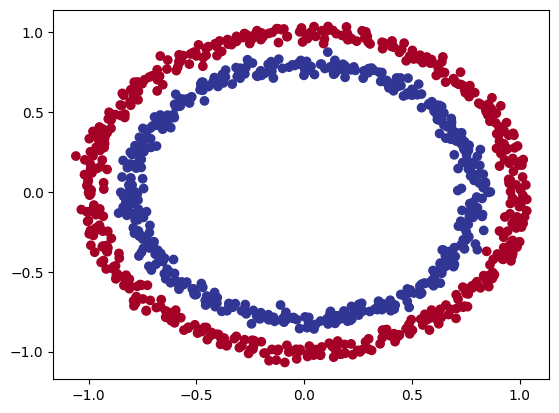

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

Alrighty, looks like we've got a problem to solve.

Let's find out how we could build a PyTorch neural network to classify dots into red (0) or blue (1).

### 1.1 Input and output shapes

And there's no surefire way to making sure they won't happen, they will.

What you can do instead is continually familiarize yourself with the shape of the data you're working with.

I like referring to it as input and output shapes.

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


This tells us the second dimension for `X` means it has two features (vector) where as `y` has a single feature (scalar).

We have two inputs for one output.

### 1.2 Turn data into tensors and create train and test splits

We've investigated the input and output shapes of our data, now let's prepare it for being used with PyTorch and for modelling.

In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

Now our data is in tensor format, let's split it into training and test sets.

We'll use `test_size=0.2` (75% training, 25% testing) and because the split happens randomly across the data, let's use `random_state=42` so the split is reproducible.

In [9]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[-0.9137, -0.3741],
         [ 0.1428,  0.8240],
         [-0.3245, -0.9184],
         [-0.6866,  0.4317],
         [-0.8008, -0.0406]]),
 tensor([0., 1., 0., 1., 1.]))

## 2. Building a model

We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.

1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing `nn.Module`.
3. Defining a loss function and optimizer.
4. Creating a training loop (this'll be in the next section).

In [10]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2.1. Building a model with non-linearity

Excellent, now `device` is setup, we can use it for any data or models we create and PyTorch will handle it on the CPU (default) or GPU if it's available.

We'll want a model capable of handling our `X` data as inputs and producing something in the shape of our `y` data as ouputs.

In other words, given `X` (features) we want our model to predict `y` (label).

Let's create a model class that:
1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of `nn.Module`).
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of `X` and `y`.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target `device`.

So far our neural networks have only been using linear (straight) line functions.

But the data we've been working with is non-linear (circles).

What do you think will happen when we introduce the capability for our model to use **non-linear actviation functions**?

Well let's see.

PyTorch has a bunch of [ready-made non-linear activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that do similiar but different things.

One of the most common and best performing is [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) (rectified linear-unit, [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)).

Rather than talk about it, let's put it in our neural network between the hidden layers in the forward pass and see what happens.

In [11]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=30)
        self.layer_2 = nn.Linear(in_features=30, out_features=30)
        self.layer_3 = nn.Linear(in_features=30, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2((self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=30, bias=True)
  (layer_2): Linear(in_features=30, out_features=30, bias=True)
  (layer_3): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
)


In [12]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

Wonderful!



In [13]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

### 3. Training a model with non-linearity

You know the drill, model, loss function, optimizer ready to go, let's create a training and testing loop.

In [14]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70391, Accuracy: 50.53% | Test Loss: 0.70575, Test Accuracy: 48.40%
Epoch: 100 | Loss: 0.67939, Accuracy: 75.47% | Test Loss: 0.68186, Test Accuracy: 70.80%
Epoch: 200 | Loss: 0.66510, Accuracy: 73.07% | Test Loss: 0.66998, Test Accuracy: 68.80%
Epoch: 300 | Loss: 0.64112, Accuracy: 84.53% | Test Loss: 0.64945, Test Accuracy: 76.40%
Epoch: 400 | Loss: 0.59946, Accuracy: 97.20% | Test Loss: 0.61325, Test Accuracy: 92.00%
Epoch: 500 | Loss: 0.52882, Accuracy: 99.33% | Test Loss: 0.55053, Test Accuracy: 98.80%
Epoch: 600 | Loss: 0.42252, Accuracy: 99.87% | Test Loss: 0.45410, Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.29756, Accuracy: 100.00% | Test Loss: 0.33633, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.19268, Accuracy: 100.00% | Test Loss: 0.23277, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.12589, Accuracy: 100.00% | Test Loss: 0.16353, Test Accuracy: 100.00%


Ho ho! That's looking far better!

In [15]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

### 4. Evaluating a model trained with non-linear activation functions

Remember how our circle data is non-linear? Well, let's see how our models predictions look now the model's been trained with non-linear activation functions.

In [16]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

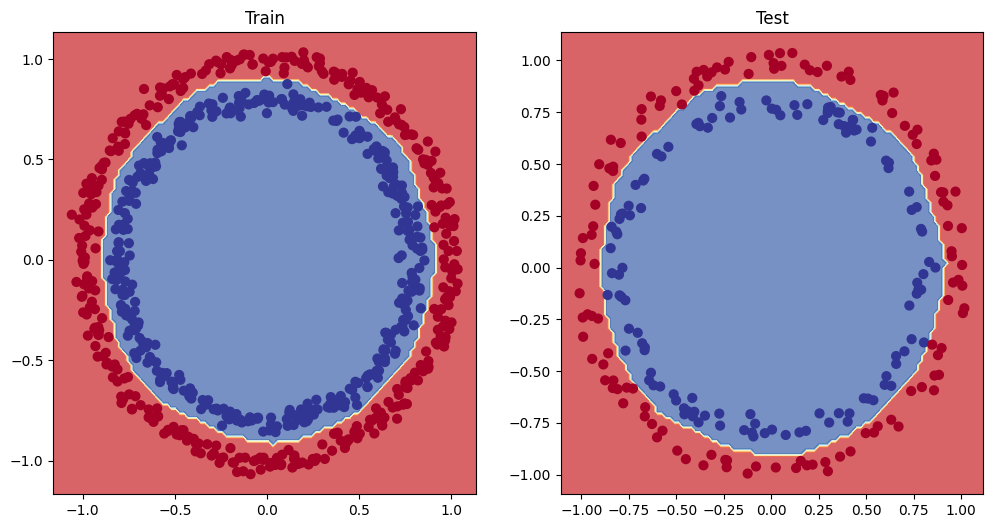

In [17]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

Nice! Now its perfect.